In [1]:
# Upgrade pip to the latest version
!pip install --upgrade pip

# Install TensorFlow and its GPU variant
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1

# Install other dependencies
!pip install opencv-python matplotlib

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\91883\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.4.1

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import cv2
import matplotlib

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)


TensorFlow version: 2.17.0
OpenCV version: 4.10.0
Matplotlib version: 3.7.2


In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\101deee2-4f41-11ef-b604-bbb9ba63edc6.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(256)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(256)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(256)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data\\anchor\\c614bd6b-4e7e-11ef-9994-bbb9ba63edc6.jpg'


In [15]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [16]:
img = preprocess('data\\anchor\\c5ba434f-4e7e-11ef-8904-bbb9ba63edc6.jpg')

In [17]:
img.numpy().max() 

0.99852943

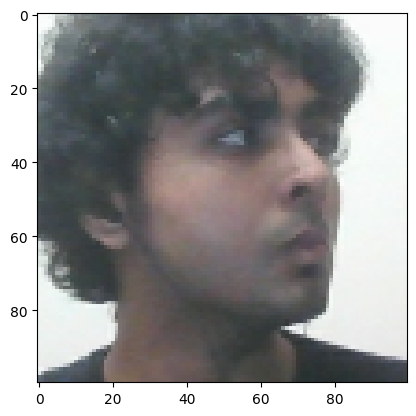

In [18]:
plt.imshow(img)

In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
samples = data.as_numpy_iterator()

In [21]:
exampple = samples.next()
exampple

(b'data\\anchor\\ef6baee5-4e7e-11ef-96de-bbb9ba63edc6.jpg',
 b'data\\positive\\da392d85-4e7f-11ef-a725-bbb9ba63edc6.jpg',
 1.0)

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*exampple)

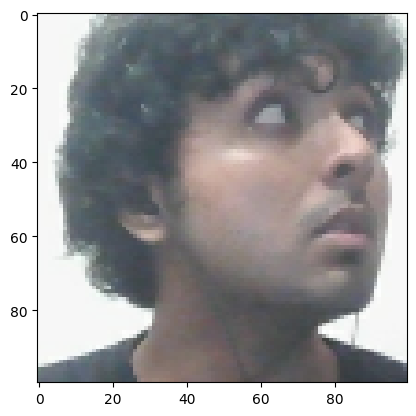

In [24]:
plt.imshow(res[1])

In [25]:
res[2]

1.0

In [26]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [27]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [32]:
l1 = L1Dist()

In [340]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_19 (L1Dist) │ (None, 4096)      │          0 │ embedding[8][0],  │
│                     │                   │            │ embedding[9][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [34]:
siamese_model = make_siamese_model()

In [35]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [37]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [39]:
test_batch = train_data.as_numpy_iterator()

In [40]:
batch_1 = test_batch.next()

In [41]:
X = batch_1[:2]

In [42]:
y = batch_1[2]

In [43]:
y

array([0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [44]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [45]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [46]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [47]:
EPOCHS = 50

In [48]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
22/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

 Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step

 Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 15/50
23/23 ━━━━━━━━━━━━━━━

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [67]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [68]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


array([[9.9208796e-01],
       [9.9788564e-01],
       [9.9925947e-01],
       [9.9956626e-01],
       [5.0726533e-07],
       [9.9847287e-01],
       [2.1641527e-07],
       [1.7476816e-08],
       [9.9999952e-01],
       [2.1952075e-10],
       [1.0000000e+00],
       [7.0381214e-12],
       [9.8912925e-01],
       [9.9988103e-01],
       [1.0000000e+00],
       [5.4940926e-13]], dtype=float32)

In [69]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

In [70]:
y_true

array([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.],
      dtype=float32)

In [71]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [72]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

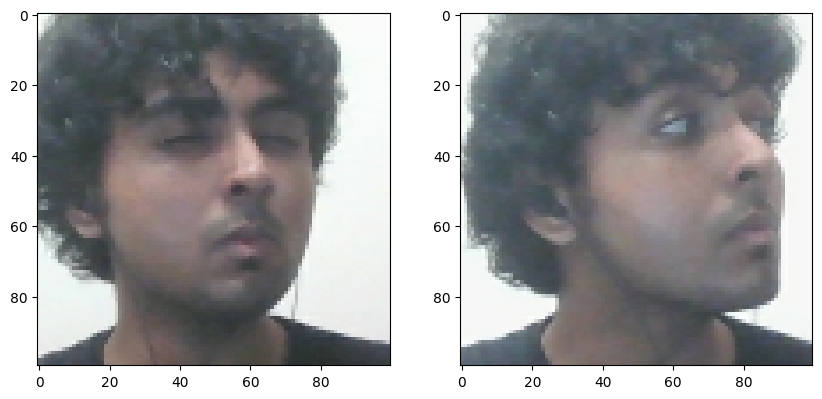

In [126]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()